In [1]:
# 5. Написать программу, позволяющую проверять для текста выполнение закона Ципфа-Мальдеброта. Программа должна:

#     1. осуществлять морфологический анализ словоформ текста;
#     2. подсчитывать частоты и ранги различных словоформ и лемм;
#     3. выводить списки самых частотных словоформ и лемм;
#     4. строить графики (реальный и ожидаемый) зависимости относительной частоты от ранга словоформы и леммы.

# Отчет: программа с комментариями, подсчитанная статистика, комментарии к способу ее подсчета, описание проведенных тестов, выводы.

# Прикладные задачи: оценка естественности текста, определение стиля/жанра текста.

In [2]:
#importing modules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize.punkt import PunktSentenceTokenizer

import pymorphy2
import string
from collections import Counter
import operator
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
#modules

In [4]:
#parse the words
def morphy(word):
    #retuning normal form of word
    #it mistakes when word has multiple meaning
    morph = pymorphy2.MorphAnalyzer()
    parse= morph.parse(word)[0]
    return parse.normal_form

def f_morphy_dict(word):
    #returns position of word
    morph=pymorphy2.MorphAnalyzer()
    parse=morph.parse(word)[0]
    return parse.tag.POS

In [5]:
#tokenizing by sentences
def Sent_tokenizing(Text):
    Text_sent_tokenized=[]
    tokenizer = PunktSentenceTokenizer()
    paragraphs = [p for p in Text.split('\n') if p] #spliting by \n
    for paragraph in paragraphs:
        Text_sent_tokenized += tokenizer.tokenize(paragraph,'russian')
    return Text_sent_tokenized

In [6]:
#tokenize by words
def Word_tokenizing(Text):
    special_words=string.punctuation
    special_words+='»'+'«'+'–'+'”'+'“'+'—' #adding punctuations, that doesnt excist in module
    Text_tokens=nltk.word_tokenize(Text)
    t_tokenized=[]
    
    #deleting puntuations
    for word in Text_tokens:
        if word not in special_words:
            t_tokenized.append(word)
    return t_tokenized

In [7]:
#making text object from file
file_name=input("Please input the file name:")
file=open(file_name,'r',encoding='UTF-8')
Text=file.read()
file.close()

Please input the file name: text.txt


In [8]:
#make list to analize morphic structure
#make dictionary to analyze style of text
Text_tokenized=Word_tokenizing(Text)
Text_morphy=[]
Text_dict={}
with tqdm(total=len(Text_tokenized)) as pbar: #to see how many times left
    for word in Text_tokenized:
        Text_morphy.append(morphy(word))
        Text_dict[word]=f_morphy_dict(word)
        pbar.update(1)

  0%|          | 0/2018 [00:00<?, ?it/s]

In [33]:
#stop words including
#words from module were not enough
stop_words_file=open("stop_words.txt",'r',encoding="utf-8")
stop_words_list=stop_words_file.read()
stop_words_file.close()
stop_words=stop_words_list.split('\n')

In [38]:
# осуществлять морфологический анализ словоформ текста;
# подсчитывать частоты и ранги различных словоформ и лемм;
# выводить списки самых частотных словоформ и лемм;
#строить графики (реальный и ожидаемый) зависимости относительной частоты от ранга словоформы и леммы.

#clearing digits
Text_cleared=[]
for word in Text_morphy:
    if not word.isdigit() and word not in stop_words:
        Text_cleared.append(word)
    pbar.update(1)

#giving Rank of text
Text_counted=dict(Counter(Text_cleared))
Text_sorted=dict(sorted(Text_counted.items(),key=operator.itemgetter(1), reverse=True))
j=1
rang={}
for word in Text_sorted.keys():
    rang[word]=j
    j+=1

#counting frequency for each words that inversely proportional of rank
#law of Zipf
word_frequency={}
for word in rang.keys():
    word_frequency[word]=0.08/rang[word]#В НКРЯ 0.08

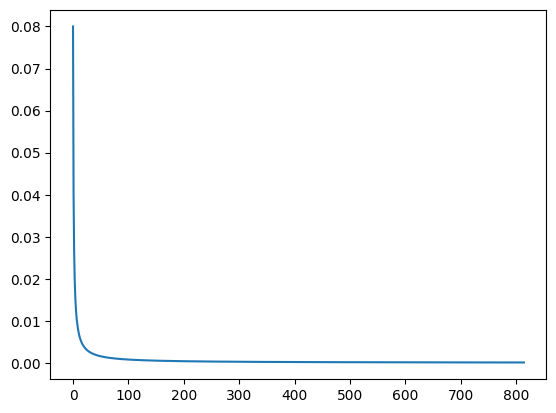

The highest 10 ranks and frequencies
лес : 0.08
лагерь : 0.04
палатка : 0.02666666666666667
дождь : 0.02
лялька : 0.016
словно : 0.013333333333333334
труд : 0.011428571428571429
рюкзак : 0.01
дерево : 0.008888888888888889
собака : 0.008


In [37]:
#printing graph of frequency/rank
plt.plot(word_frequency.values()) #y-gives frequency
plt.show()

#printing the highest 10 values
key=list(word_frequency.keys())
value=list(word_frequency.values())
print('The highest 10 ranks and frequencies')
for i in range(10): 
    print(key[i],':',value[i])

In [31]:
#определение стиля/жанра текста.

#counting параметр β, отражающий соотношение динамичности и статичности текстов коллекции
# #(гл+сущ) + #(гл+нар) + #(деепр+сущ) + #(деепр+нар) )/(#(сущ+сущ) + #(прил+сущ)), где # – количество конструкций определённого типа
Dict_for_beta={'VERB+NOUN':0,'VERB+ADVB':0,'GRND+NOUN':0,'GRND+ADVB':0,'NOUN+NOUN':0,'ADJF+NOUN':0}
prev=''
for word in Text_dict.keys():
    if prev=='':
        prev=word
        continue
    if Text_dict[prev]=='VERB':
        if Text_dict[word]=='NOUN':
            Dict_for_beta['VERB+NOUN']+=1
        elif Text_dict[word]=='ADVB':
            Dict_for_beta['VERB+ADVB']+=1
    elif Text_dict[prev]=='GRND':
        if Text_dict[word]=='NOUN':
            Dict_for_beta['GRND+NOUN']+=1
        elif Text_dict[word]=='ADVB':
            Dict_for_beta['GRND+ADVB']+=1
    elif Text_dict[prev]=='NOUN':
        if Text_dict[word]=='NOUN':
            Dict_for_beta['NOUN+NOUN']+=1
    elif Text_dict[prev]=='ADJF':
        if Text_dict[word]=='NOUN':
            Dict_for_beta['ADJF+NOUN']+=1
    prev=word

Beta_up=(Dict_for_beta['VERB+NOUN']+Dict_for_beta['VERB+ADVB']+Dict_for_beta['GRND+NOUN']+Dict_for_beta['GRND+ADVB'])
Beta_down=Dict_for_beta['NOUN+NOUN']+Dict_for_beta['ADJF+NOUN']
Beta=Beta_up/Beta_down

#counting midium длины предложения
#midium length=length of each sentece / length of all sentences divided by sentence
Sent_tokens=Sent_tokenizing(Text)
Sent_tokenized=[]
for sent in Sent_tokens:
    Sent_tokenized.append(Word_tokenizing(sent))
mid_len_sent=0
for sent in Sent_tokenized:
    mid_len_sent+=len(sent)
mid_len_sent/=len(Sent_tokens)

#calculating other parameter
Dict_count=dict(Counter(Text_dict.values()))
NPRO=Dict_count['NPRO']/len(Text_counted) #доля частиц
PRCL=Dict_count['PRCL']/len(Text_counted) #доля местоимений
ADJF=Dict_count['ADJF']/len(Text_counted) #доля прилагательных

In [32]:
if mid_len_sent>=18 and Beta<=0.1:
    print('The type of text: Деловой стиль')
elif NPRO>=0.02 and PRCL>=0.03:
    print('The type of text: Художественный стиль')
elif 0.1<=ADJF<=0.2 and NPRO<=0.025 and Beta<=0.32:
    print('The type of text: Научный стиль')
else:
    print('The type of text: Публицистический стиль')

print()
print(Dict_for_beta)
print(f"\nmidium length of sentences= {mid_len_sent}")
print(f"доля частиц= {NPRO}\nдоля местоимений= {PRCL}\nдоля прилагательных= {ADJF}")

The type of text: Публицистический стиль

{'VERB+NOUN': 64, 'VERB+ADVB': 10, 'GRND+NOUN': 23, 'GRND+ADVB': 7, 'NOUN+NOUN': 161, 'ADJF+NOUN': 146}

midium length of sentences= 15.404580152671755
доля частиц= 0.03558282208588957
доля местоимений= 0.022085889570552148
доля прилагательных= 0.249079754601227
